In [79]:
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation, Flatten
from keras.layers import Conv1D, LSTM, Dropout, Bidirectional,LayerNormalization,SimpleRNN
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [80]:
df_train = pd.read_csv('./data/DailyDelhiClimate/train.csv', index_col=0)
df_test = pd.read_csv('./data/DailyDelhiClimate/test.csv', index_col=0)

In [81]:
df_train.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [82]:
X_train, y_train = df_train[['humidity', 'wind_speed', 'meanpressure']], df_train[['meantemp']]
X_test, y_test = df_test[['humidity', 'wind_speed', 'meanpressure']], df_test[['meantemp']]

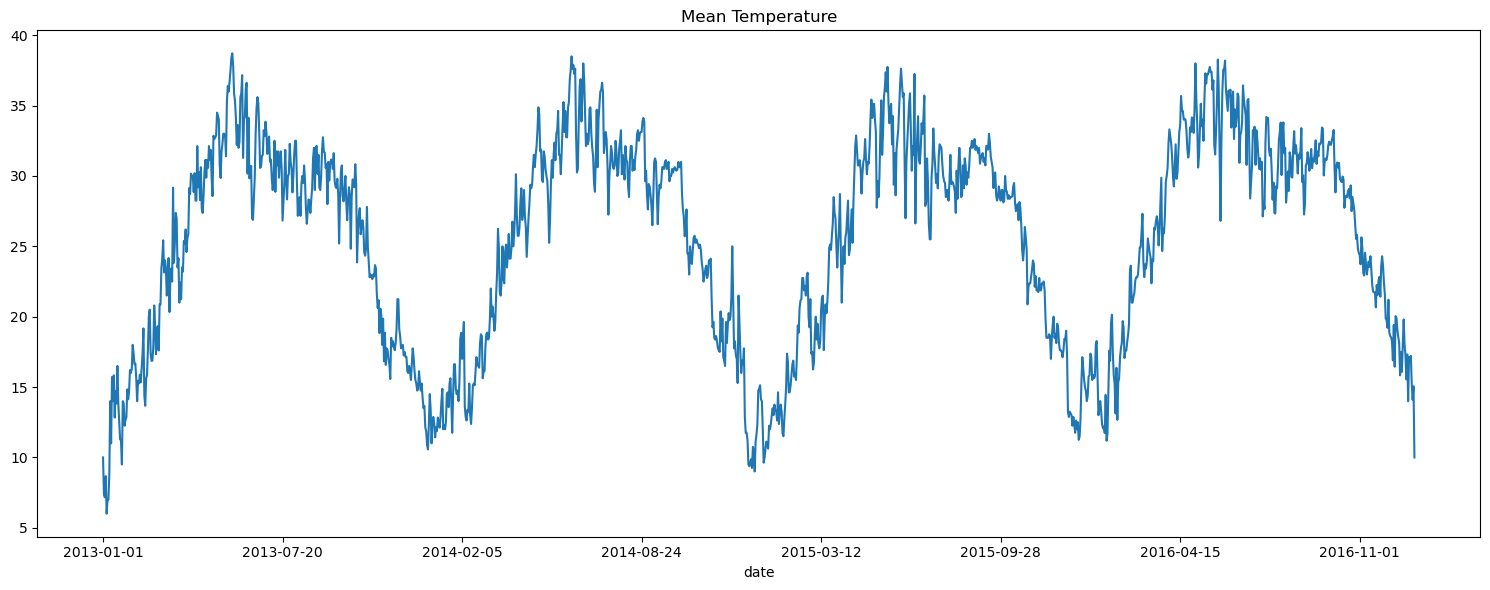

In [83]:
plt.figure(figsize=(15, 6))
df_train['meantemp'].plot()
plt.title("Mean Temperature")
plt.tight_layout()
plt.show()

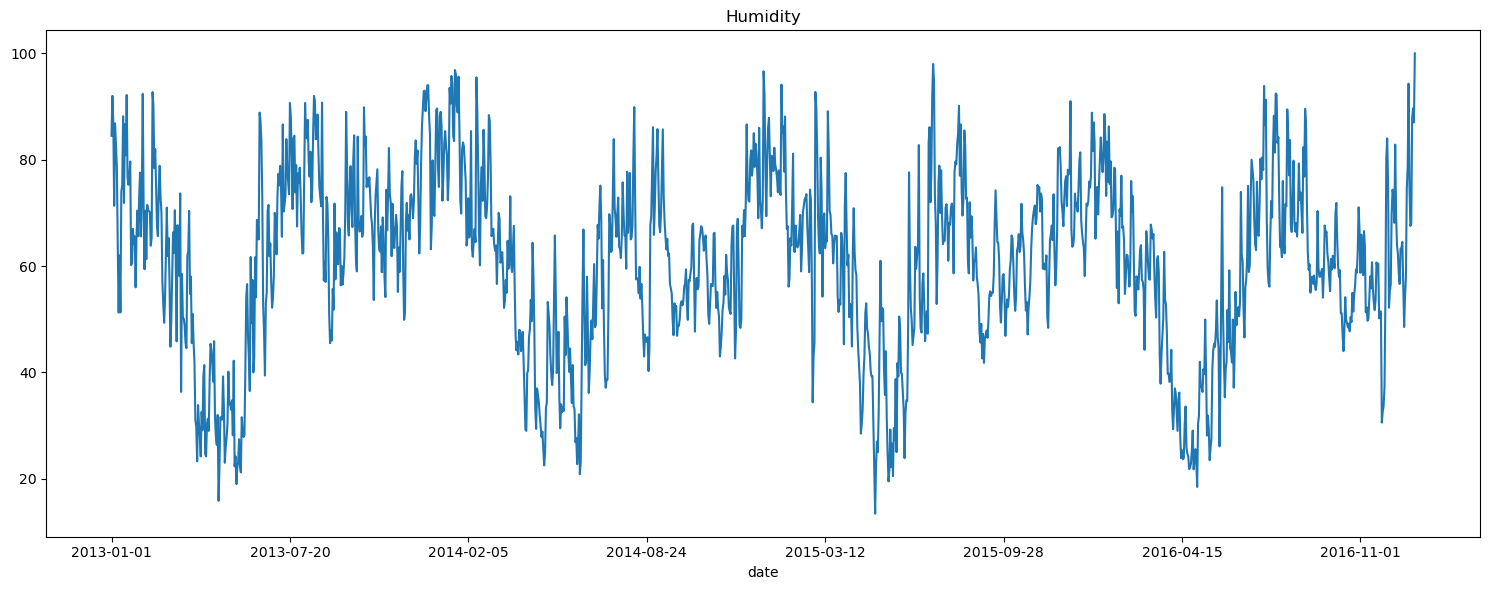

In [84]:
plt.figure(figsize=(15, 6))
df_train["humidity"].plot()
plt.title("Humidity")
plt.tight_layout()
plt.show()

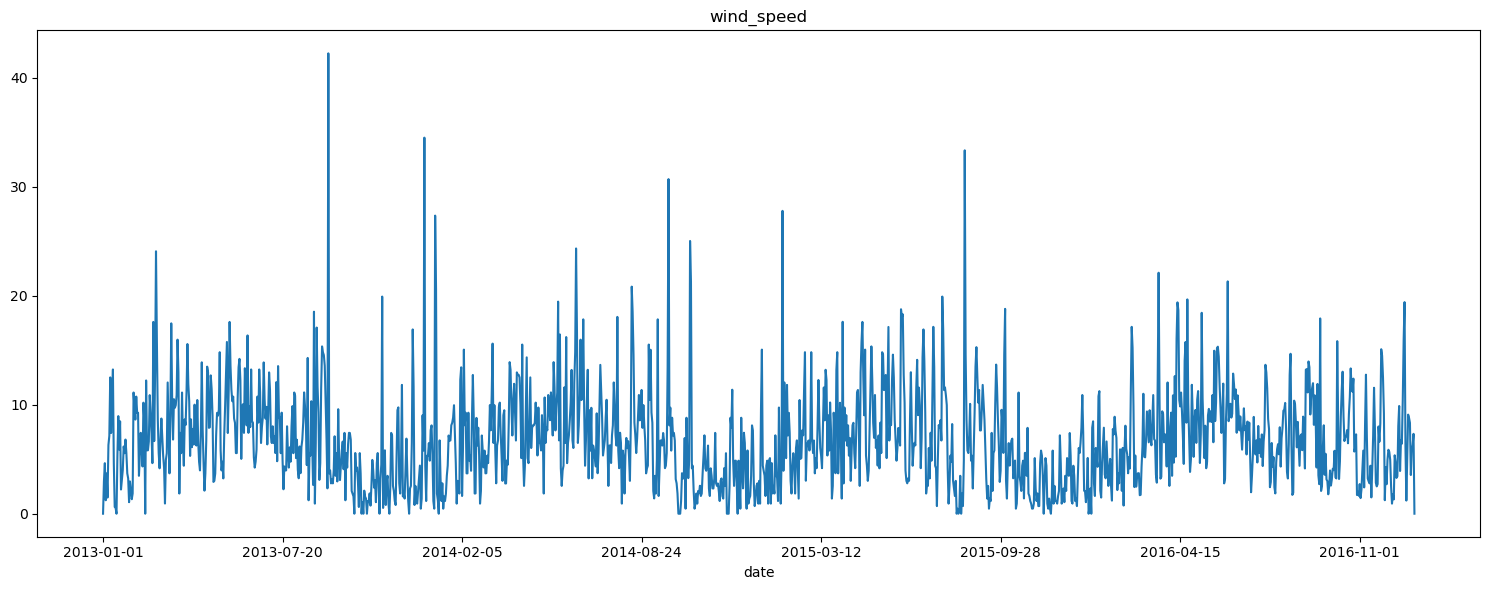

In [85]:
plt.figure(figsize=(15, 6))
df_train["wind_speed"].plot()
plt.title("wind_speed")
plt.tight_layout()
plt.show()

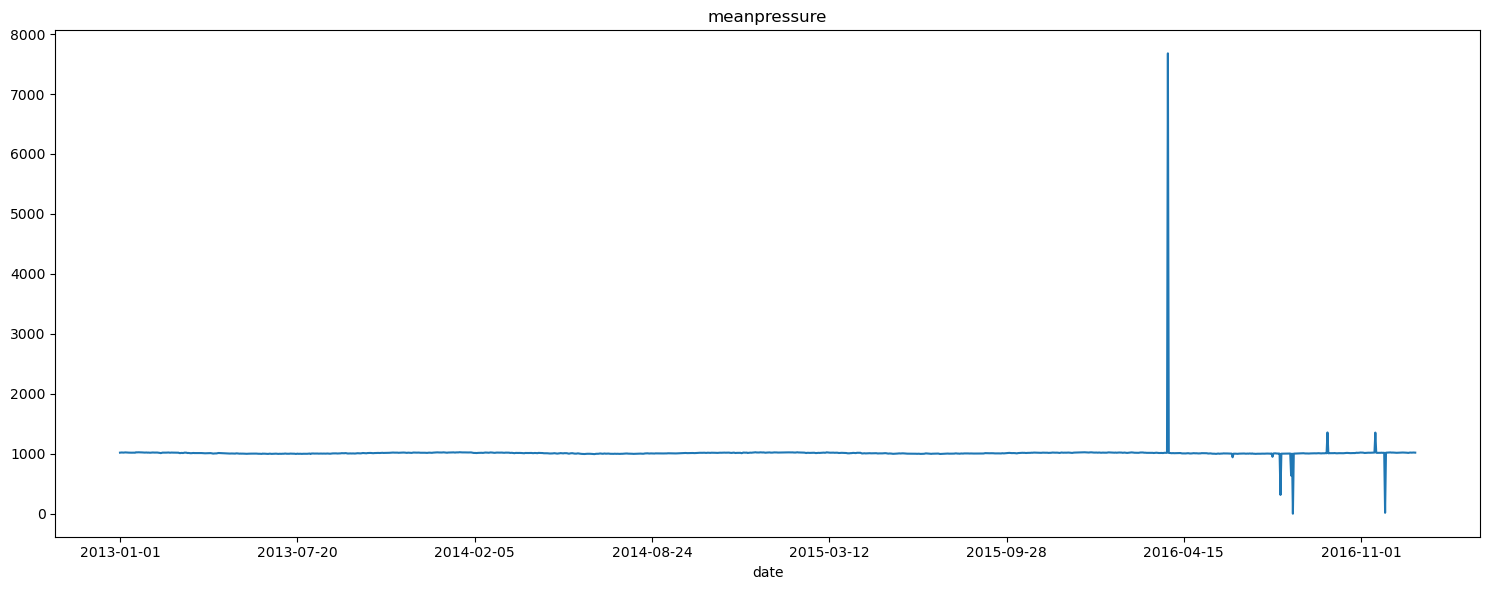

In [86]:
plt.figure(figsize=(15, 6))
df_train["meanpressure"].plot()
plt.title("meanpressure")
plt.tight_layout()
plt.show()

In [87]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(np.array(X_train))
X_test = scaler.transform(np.array(X_test))
y_train = scaler.fit_transform(np.array(y_train))
y_test = scaler.transform(np.array(y_test))

In [88]:
X_train, X_train.shape

(array([[0.8209571 , 0.        , 0.13260331],
        [0.90759076, 0.07058266, 0.132881  ],
        [0.84983498, 0.10974262, 0.13299381],
        ...,
        [0.88063806, 0.14842886, 0.13289464],
        [0.84983498, 0.17349597, 0.13265971],
        [1.        , 0.        , 0.1326467 ]]),
 (1462, 3))

In [89]:
y_train, y_train.shape

(array([[0.12227074],
        [0.04279476],
        [0.0356623 ],
        ...,
        [0.24745269],
        [0.276718  ],
        [0.12227074]]),
 (1462, 1))

In [90]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [91]:
time_step = 6
step = 1

def split_sequences(Xdata, ydata, time_steps, steps):
    X, y = list(), list()
    length = len(ydata)
    for i in range(0, length, steps):

        end_ix = i + time_steps

        if end_ix > length:
            break

        seq_x, seq_y = Xdata[i:end_ix], ydata[end_ix-1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [92]:
X_train, y_train = split_sequences(X_train, y_train, time_step, step)
X_test, y_test = split_sequences(X_test, y_test, time_step, step)

In [93]:
X_train

array([[[0.8209571 , 0.        , 0.13260331],
        [0.90759076, 0.07058266, 0.132881  ],
        [0.84983498, 0.10974262, 0.13299381],
        [0.66886689, 0.02921206, 0.13279856],
        [0.84790979, 0.08763619, 0.13271178],
        [0.80132013, 0.03505448, 0.13290703]],

       [[0.90759076, 0.07058266, 0.132881  ],
        [0.84983498, 0.10974262, 0.13299381],
        [0.66886689, 0.02921206, 0.13279856],
        [0.84790979, 0.08763619, 0.13271178],
        [0.80132013, 0.03505448, 0.13290703],
        [0.75280528, 0.14921838, 0.13316737]],

       [[0.84983498, 0.10974262, 0.13299381],
        [0.66886689, 0.02921206, 0.13279856],
        [0.84790979, 0.08763619, 0.13271178],
        [0.80132013, 0.03505448, 0.13290703],
        [0.75280528, 0.14921838, 0.13316737],
        [0.58085809, 0.16918184, 0.13300001]],

       ...,

       [[0.93415842, 0.21518238, 0.13243192],
        [0.70957096, 0.20805804, 0.13277067],
        [0.62516502, 0.19741829, 0.1328029 ],
        [0.6308

In [94]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1457, 6, 3), (109, 6, 3), (1457, 1), (109, 1))

In [95]:
model = Sequential()
model.add(SimpleRNN(64,input_shape = (X_train.shape[1:]), return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dropout(0.3))
model.add(Dense(8))
model.add(Dense(1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 6, 64)             4352      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 7729 (30.19 KB)
Trainable params: 7729 (30.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [97]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.3, shuffle=False)

Epoch 1/500
32/32 [==============================] - 14s 112ms/step - loss: 0.2222 - mae: 0.3896 - val_loss: 0.0421 - val_mae: 0.1682
Epoch 2/500
32/32 [==============================] - 0s 11ms/step - loss: 0.0907 - mae: 0.2464 - val_loss: 0.0366 - val_mae: 0.1561
Epoch 3/500
32/32 [==============================] - 1s 19ms/step - loss: 0.0703 - mae: 0.2178 - val_loss: 0.0349 - val_mae: 0.1525
Epoch 4/500
32/32 [==============================] - 1s 17ms/step - loss: 0.0663 - mae: 0.2124 - val_loss: 0.0356 - val_mae: 0.1533
Epoch 5/500
32/32 [==============================] - 0s 10ms/step - loss: 0.0676 - mae: 0.2171 - val_loss: 0.0324 - val_mae: 0.1481
Epoch 6/500
32/32 [==============================] - 0s 12ms/step - loss: 0.0617 - mae: 0.2066 - val_loss: 0.0326 - val_mae: 0.1488
Epoch 7/500
32/32 [==============================] - 0s 11ms/step - loss: 0.0566 - mae: 0.1991 - val_loss: 0.0345 - val_mae: 0.1533
Epoch 8/500
32/32 [==============================] - 0s 11ms/step - loss: 

Epoch 63/500
32/32 [==============================] - 0s 12ms/step - loss: 0.0349 - mae: 0.1589 - val_loss: 0.0301 - val_mae: 0.1445
Epoch 64/500
32/32 [==============================] - 1s 21ms/step - loss: 0.0350 - mae: 0.1596 - val_loss: 0.0304 - val_mae: 0.1442
Epoch 65/500
32/32 [==============================] - 0s 14ms/step - loss: 0.0360 - mae: 0.1612 - val_loss: 0.0302 - val_mae: 0.1441
Epoch 66/500
32/32 [==============================] - 0s 16ms/step - loss: 0.0349 - mae: 0.1584 - val_loss: 0.0301 - val_mae: 0.1440
Epoch 67/500
32/32 [==============================] - 0s 13ms/step - loss: 0.0352 - mae: 0.1601 - val_loss: 0.0302 - val_mae: 0.1441
Epoch 68/500
32/32 [==============================] - 1s 18ms/step - loss: 0.0351 - mae: 0.1594 - val_loss: 0.0302 - val_mae: 0.1440
Epoch 69/500
32/32 [==============================] - 1s 16ms/step - loss: 0.0354 - mae: 0.1595 - val_loss: 0.0300 - val_mae: 0.1440
Epoch 70/500
32/32 [==============================] - 0s 14ms/step - 

32/32 [==============================] - 1s 16ms/step - loss: 0.0332 - mae: 0.1542 - val_loss: 0.0297 - val_mae: 0.1439
Epoch 125/500
32/32 [==============================] - 0s 14ms/step - loss: 0.0332 - mae: 0.1556 - val_loss: 0.0297 - val_mae: 0.1438
Epoch 126/500
32/32 [==============================] - 0s 15ms/step - loss: 0.0331 - mae: 0.1557 - val_loss: 0.0297 - val_mae: 0.1438
Epoch 127/500
32/32 [==============================] - 1s 16ms/step - loss: 0.0327 - mae: 0.1541 - val_loss: 0.0297 - val_mae: 0.1438
Epoch 128/500
32/32 [==============================] - 0s 11ms/step - loss: 0.0332 - mae: 0.1563 - val_loss: 0.0297 - val_mae: 0.1437
Epoch 129/500
32/32 [==============================] - 0s 13ms/step - loss: 0.0333 - mae: 0.1550 - val_loss: 0.0297 - val_mae: 0.1439
Epoch 130/500
32/32 [==============================] - 0s 13ms/step - loss: 0.0329 - mae: 0.1542 - val_loss: 0.0297 - val_mae: 0.1439
Epoch 131/500
32/32 [==============================] - 0s 10ms/step - loss: 

32/32 [==============================] - 1s 17ms/step - loss: 0.0325 - mae: 0.1534 - val_loss: 0.0295 - val_mae: 0.1435
Epoch 186/500
32/32 [==============================] - 0s 13ms/step - loss: 0.0326 - mae: 0.1537 - val_loss: 0.0296 - val_mae: 0.1437
Epoch 187/500
32/32 [==============================] - 1s 18ms/step - loss: 0.0328 - mae: 0.1541 - val_loss: 0.0296 - val_mae: 0.1433
Epoch 188/500
32/32 [==============================] - 0s 10ms/step - loss: 0.0328 - mae: 0.1542 - val_loss: 0.0295 - val_mae: 0.1436
Epoch 189/500
32/32 [==============================] - 0s 13ms/step - loss: 0.0324 - mae: 0.1532 - val_loss: 0.0296 - val_mae: 0.1432
Epoch 190/500
32/32 [==============================] - 1s 24ms/step - loss: 0.0325 - mae: 0.1531 - val_loss: 0.0295 - val_mae: 0.1433
Epoch 191/500
32/32 [==============================] - 1s 18ms/step - loss: 0.0329 - mae: 0.1548 - val_loss: 0.0294 - val_mae: 0.1435
Epoch 192/500
32/32 [==============================] - 1s 18ms/step - loss: 

32/32 [==============================] - 0s 14ms/step - loss: 0.0327 - mae: 0.1539 - val_loss: 0.0293 - val_mae: 0.1431
Epoch 247/500
32/32 [==============================] - 0s 16ms/step - loss: 0.0327 - mae: 0.1535 - val_loss: 0.0293 - val_mae: 0.1432
Epoch 248/500
32/32 [==============================] - 1s 30ms/step - loss: 0.0326 - mae: 0.1533 - val_loss: 0.0293 - val_mae: 0.1429
Epoch 249/500
32/32 [==============================] - 0s 15ms/step - loss: 0.0320 - mae: 0.1517 - val_loss: 0.0295 - val_mae: 0.1434
Epoch 250/500
32/32 [==============================] - 0s 15ms/step - loss: 0.0322 - mae: 0.1527 - val_loss: 0.0293 - val_mae: 0.1433
Epoch 251/500
32/32 [==============================] - 0s 14ms/step - loss: 0.0320 - mae: 0.1524 - val_loss: 0.0294 - val_mae: 0.1429
Epoch 252/500
32/32 [==============================] - 0s 16ms/step - loss: 0.0326 - mae: 0.1541 - val_loss: 0.0293 - val_mae: 0.1429
Epoch 253/500
32/32 [==============================] - 0s 15ms/step - loss: 

32/32 [==============================] - 0s 14ms/step - loss: 0.0322 - mae: 0.1521 - val_loss: 0.0291 - val_mae: 0.1427
Epoch 308/500
32/32 [==============================] - 0s 15ms/step - loss: 0.0318 - mae: 0.1513 - val_loss: 0.0291 - val_mae: 0.1426
Epoch 309/500
32/32 [==============================] - 0s 11ms/step - loss: 0.0324 - mae: 0.1528 - val_loss: 0.0291 - val_mae: 0.1426
Epoch 310/500
32/32 [==============================] - 0s 12ms/step - loss: 0.0320 - mae: 0.1524 - val_loss: 0.0291 - val_mae: 0.1424
Epoch 311/500
32/32 [==============================] - 0s 11ms/step - loss: 0.0324 - mae: 0.1540 - val_loss: 0.0291 - val_mae: 0.1425
Epoch 312/500
32/32 [==============================] - 0s 10ms/step - loss: 0.0321 - mae: 0.1519 - val_loss: 0.0291 - val_mae: 0.1423
Epoch 313/500
32/32 [==============================] - 0s 10ms/step - loss: 0.0324 - mae: 0.1531 - val_loss: 0.0291 - val_mae: 0.1427
Epoch 314/500
32/32 [==============================] - 0s 10ms/step - loss: 

32/32 [==============================] - 0s 16ms/step - loss: 0.0323 - mae: 0.1529 - val_loss: 0.0289 - val_mae: 0.1417
Epoch 369/500
32/32 [==============================] - 0s 15ms/step - loss: 0.0323 - mae: 0.1524 - val_loss: 0.0287 - val_mae: 0.1418
Epoch 370/500
32/32 [==============================] - 1s 17ms/step - loss: 0.0319 - mae: 0.1519 - val_loss: 0.0288 - val_mae: 0.1419
Epoch 371/500
32/32 [==============================] - 0s 13ms/step - loss: 0.0321 - mae: 0.1520 - val_loss: 0.0288 - val_mae: 0.1415
Epoch 372/500
32/32 [==============================] - 0s 12ms/step - loss: 0.0322 - mae: 0.1519 - val_loss: 0.0287 - val_mae: 0.1416
Epoch 373/500
32/32 [==============================] - 1s 17ms/step - loss: 0.0315 - mae: 0.1510 - val_loss: 0.0287 - val_mae: 0.1415
Epoch 374/500
32/32 [==============================] - 1s 17ms/step - loss: 0.0316 - mae: 0.1510 - val_loss: 0.0288 - val_mae: 0.1416
Epoch 375/500
32/32 [==============================] - 0s 14ms/step - loss: 

32/32 [==============================] - 0s 11ms/step - loss: 0.0319 - mae: 0.1515 - val_loss: 0.0283 - val_mae: 0.1403
Epoch 430/500
32/32 [==============================] - 0s 16ms/step - loss: 0.0312 - mae: 0.1491 - val_loss: 0.0283 - val_mae: 0.1402
Epoch 431/500
32/32 [==============================] - 0s 15ms/step - loss: 0.0313 - mae: 0.1499 - val_loss: 0.0283 - val_mae: 0.1402
Epoch 432/500
32/32 [==============================] - 0s 12ms/step - loss: 0.0313 - mae: 0.1501 - val_loss: 0.0283 - val_mae: 0.1400
Epoch 433/500
32/32 [==============================] - 0s 14ms/step - loss: 0.0320 - mae: 0.1517 - val_loss: 0.0283 - val_mae: 0.1402
Epoch 434/500
32/32 [==============================] - 0s 11ms/step - loss: 0.0316 - mae: 0.1505 - val_loss: 0.0283 - val_mae: 0.1401
Epoch 435/500
32/32 [==============================] - 0s 13ms/step - loss: 0.0313 - mae: 0.1498 - val_loss: 0.0283 - val_mae: 0.1400
Epoch 436/500
32/32 [==============================] - 0s 13ms/step - loss: 

32/32 [==============================] - 0s 14ms/step - loss: 0.0310 - mae: 0.1486 - val_loss: 0.0279 - val_mae: 0.1391
Epoch 491/500
32/32 [==============================] - 0s 12ms/step - loss: 0.0311 - mae: 0.1497 - val_loss: 0.0279 - val_mae: 0.1386
Epoch 492/500
32/32 [==============================] - 0s 11ms/step - loss: 0.0306 - mae: 0.1475 - val_loss: 0.0279 - val_mae: 0.1388
Epoch 493/500
32/32 [==============================] - 1s 20ms/step - loss: 0.0309 - mae: 0.1485 - val_loss: 0.0279 - val_mae: 0.1384
Epoch 494/500
32/32 [==============================] - 1s 21ms/step - loss: 0.0311 - mae: 0.1490 - val_loss: 0.0279 - val_mae: 0.1388
Epoch 495/500
32/32 [==============================] - 0s 12ms/step - loss: 0.0310 - mae: 0.1495 - val_loss: 0.0279 - val_mae: 0.1386
Epoch 496/500
32/32 [==============================] - 0s 11ms/step - loss: 0.0309 - mae: 0.1487 - val_loss: 0.0279 - val_mae: 0.1390
Epoch 497/500
32/32 [==============================] - 0s 12ms/step - loss: 

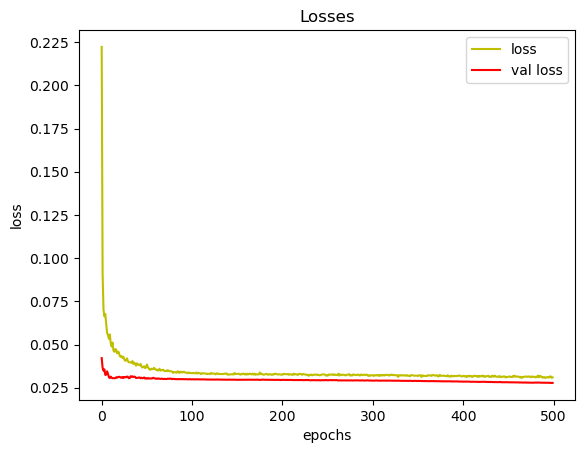

In [98]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.arange(0, len(history.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [99]:
y_pred = model.predict(X_test)

4/4 [==============================] - 2s 8ms/step


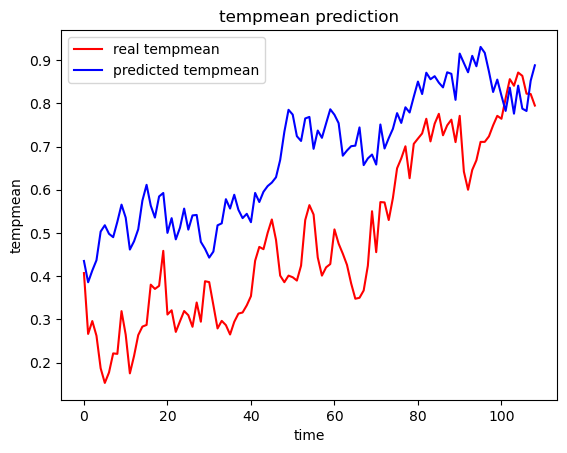

In [100]:
plt.plot(y_test, color='red', label='real tempmean')
plt.plot(y_pred, color='blue', label='predicted tempmean')
plt.title('tempmean prediction')
plt.xlabel('time')
plt.ylabel('tempmean')
plt.legend()
plt.show()